# Introduction

We train a MLP for house price prediction using TensorFlow/Keras.

The dataset can be found here:
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

We also compare the performace of the MLP with a multi-variate linear regressor.

Model: "HousePricePredictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 80)             │        17,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,641 (80.63 KB)

 Trainable params: 20,641 (80.63 KB)

 Non-trainable params: 0 (0.00 B)

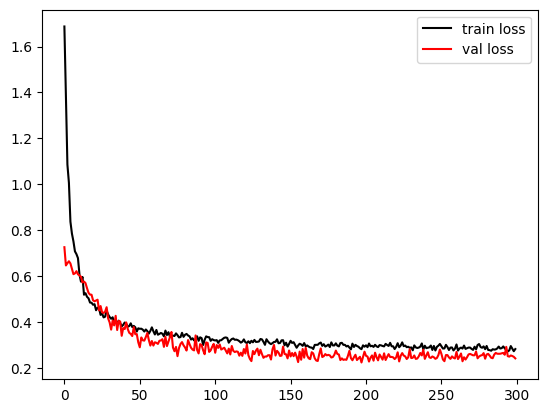

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAPE MLP: 9.91%

Comparing with dummy baseline ...
MAPE dummy baseline: 40.30%
MLP is 30.39% better compared to dummy baseline

Comparing with multi-variate linear regression ...
MAPE Linear Regression: 9.00%
Difference MAPE LR - MAPE MLP: -0.92%


In [35]:
# Deactivate TensorFlow GPU support 
# since TF/Keras seems not to support the new RTX PRO 6000 Blackwell (Compute Capability 12.0)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # GPU deaktivieren

import random
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import tensorflow as tf

# For reproducible results (starting with the same MLP)
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# 1. Read in the dataset
URL = "http://www.juergenbrauer.org/datasets/0009_real_estates_ames.csv"
df = pandas.read_csv(URL)

# 2. Prepare to use all feature columns that are complete
df = df.dropna(axis="columns")
df = pandas.get_dummies(df)

# 3. Define inputs-/outputs for the model
target_feature = "SalePrice"
x = df.drop(target_feature, axis="columns")
y = df[ [target_feature] ]

# 4. Split example data into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# 5. Scale the data (important for MLPs!)
s_input = PowerTransformer()
s_output = PowerTransformer()
s_input.fit(x_train.values)
s_output.fit(y_train.values)
x_train_scaled = s_input.transform(x_train.values)
y_train_scaled = s_output.transform(y_train.values)

# 6. Build up a MLP and train it
nr_inputs = len(x_train.columns)
model = tf.keras.Sequential(name="HousePricePredictor")
model.add( tf.keras.layers.InputLayer(shape=(nr_inputs,) ) )
model.add( tf.keras.layers.Dense(80, activation="relu", name="hidden1") )
model.add( tf.keras.layers.Dropout(0.66))
model.add( tf.keras.layers.Dense(40, activation="relu", name="hidden2") )
model.add( tf.keras.layers.Dropout(0.66))
model.add( tf.keras.layers.Dense(1, name="output") )
model.compile(optimizer="rmsprop", loss="mae")
model.summary()
h = model.fit(x_train_scaled, y_train_scaled, validation_split=0.1, epochs=300, verbose=0)
plt.plot(h.history["loss"], color="black", label="train loss")
plt.plot(h.history["val_loss"], color="red", label="val loss")
plt.legend()
plt.show()

# 7. Test model on test data
x_test_scaled = s_input.transform(x_test.values)
preds_scaled = model.predict(x_test_scaled)
preds_dollar = s_output.inverse_transform(preds_scaled)
MAPE = mean_absolute_percentage_error(y_test, preds_dollar.flatten()) * 100
print(f"MAPE MLP: {MAPE:.2f}%")

# 8. Compare MLP with dummy baseline
print("\nComparing with dummy baseline ...")
preds_baseline = [y_train["SalePrice"].mean()] * len(x_test)
MAPE_dummy_baseline = mean_absolute_percentage_error(y_test, preds_baseline) * 100
print(f"MAPE dummy baseline: {MAPE_dummy_baseline:.2f}%")
print(f"MLP is {MAPE_dummy_baseline - MAPE:.2f}% better compared to dummy baseline")

# 9. Compare with multi-variate linear regression
print("\nComparing with multi-variate linear regression ...")
lin_reg = LinearRegression()
lin_reg.fit(x_train_scaled, y_train_scaled)
preds_lr_scaled = lin_reg.predict(x_test_scaled)
preds_lr = s_output.inverse_transform(preds_lr_scaled)
MAPE_lr = mean_absolute_percentage_error(y_test, preds_lr) * 100
print(f"MAPE Linear Regression: {MAPE_lr:.2f}%")
print(f"Difference MAPE LR - MAPE MLP: {MAPE_lr - MAPE:.2f}%")


# What is the PowerTransformer?

The PowerTransformer in scikit-learn is used to apply a power-based transformation to numerical features in order to make their distribution closer to a normal (Gaussian) distribution.

This often helps many machine learning models (e.g. linear models, SVMs, neural networks) train more stably and perform better.

For the formulas behind the power transform, see: https://en.wikipedia.org/wiki/Power_transform 

In the following demo we use the [Exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) which gives each value x a probability p(x) where the probability is defined on basis of a exponential function.

The exact definition used in NumPy can be found here:
https://numpy.org/doc/2.1/reference/random/generated/numpy.random.exponential.html 

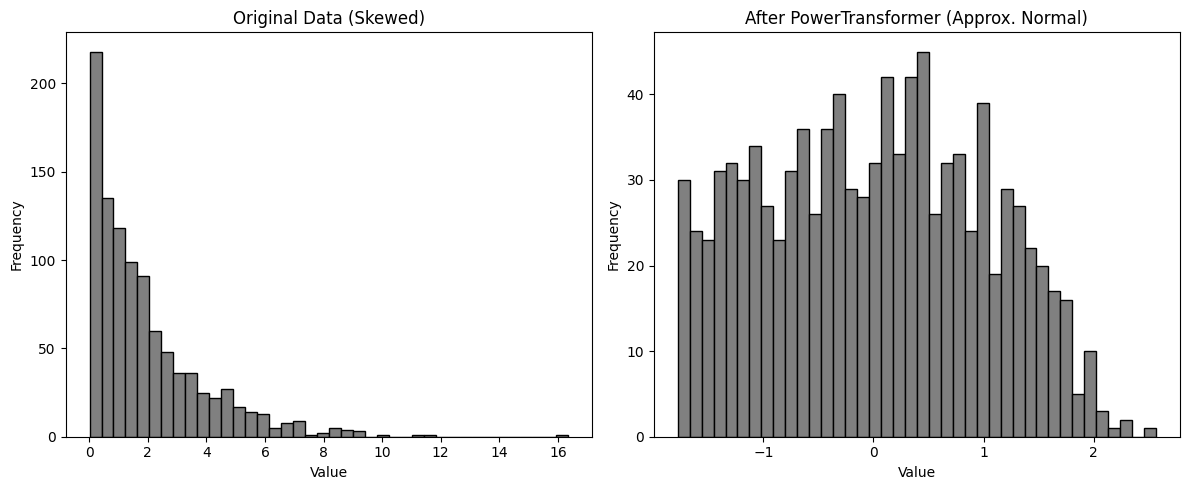

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# -----------------------------
# 1. Create skewed data
# -----------------------------
np.random.seed(42)
X = np.random.exponential(scale=2.0, size=1000).reshape(-1, 1)

# -----------------------------
# 2. Apply PowerTransformer
# -----------------------------
pt = PowerTransformer(method="yeo-johnson", standardize=True)
X_transformed = pt.fit_transform(X)

# -----------------------------
# 3. Plot before and after
# -----------------------------
plt.figure(figsize=(12, 5))

# Original data
plt.subplot(1, 2, 1)
plt.hist(X, bins=40, color="gray", edgecolor="black")
plt.title("Original Data (Skewed)")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Transformed data
plt.subplot(1, 2, 2)
plt.hist(X_transformed, bins=40, color="gray", edgecolor="black")
plt.title("After PowerTransformer (Approx. Normal)")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()